In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Generate dataset

In [2]:
np.random.seed(12)
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 174
1 163
2 163


In [3]:
x = np.zeros((500,))

In [4]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [5]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.2459800877058114)

In [6]:
print(x.shape,y.shape)

(500,) (500,)


In [7]:
idx= []
for i in range(3):
  idx.append(y==i)

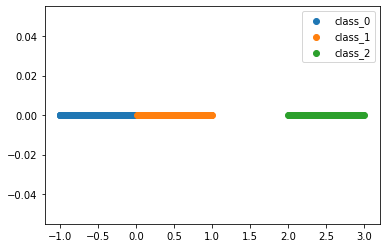

In [8]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [9]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(163,)

In [10]:
np.unique(bg_idx).shape

(163,)

In [11]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [12]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([-1.00805526e-16]), array([-1.7163962]))

In [13]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [14]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.37808847]))

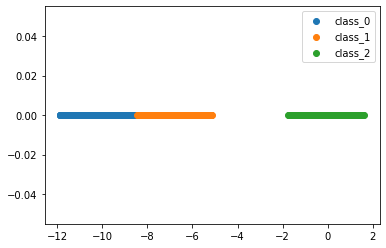

In [15]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [16]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [17]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
foreground 1 present at 8
(9,)
1 8


In [18]:
a.shape

(9,)

In [19]:
np.reshape(a,(9,1))

array([[-0.80241043],
       [ 1.00228507],
       [-0.81132988],
       [ 1.2774409 ],
       [ 0.57398646],
       [-0.91850331],
       [ 0.6600648 ],
       [ 0.57398646],
       [-7.63155537]])

In [20]:
a=np.reshape(a,(3,3))

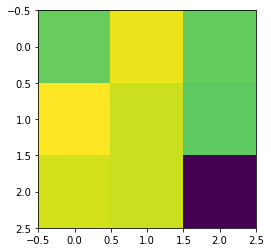

In [21]:
plt.imshow(a)

In [22]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [23]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [24]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 9), array([-10.62460519,   1.43580093,   0.13695373,  -0.4252276 ,
         -0.91850331,  -0.12909751,  -1.73154424,   0.75582313,
          0.6640638 ]))

In [25]:
for j in range(9):
  print(mosaic_list_of_images[0][j])
  

-10.624605191016078
1.4358009314866034
0.13695372724012772
-0.4252275951078302
-0.9185033095974854
-0.12909750858981067
-1.7315442430857817
0.7558231343879587
0.6640638025673503


In [26]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [27]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [28]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [29]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(1, 1, bias= False)
    # self.fc2 = nn.Linear(2, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 1)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [30]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(1, 1)


  def forward(self, x):
    x = x.view(-1, 1)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [31]:
import torch.optim as optim

def train(train_loader, test_loader, focus_net, classify):    
  criterion = nn.BCEWithLogitsLoss()
  optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
  optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

  print('-'*50)
  print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)
  nos_epochs = 1000
  loss_ret=0.0
  every_what_epoch = 1

  for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    epoch_loss = []
    cnt=0

    iteration = desired_num // batch
    
    #training data set
    if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
      print(epoch+1,"updating focus_net, classify_net is freezed")
      print("--"*40)
    elif ((epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
      print(epoch+1,"updating classify_net, focus_net is freezed")
      print("--"*40)    
    for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      inputs = inputs.double()
      labels = labels.float()
      # zero the parameter gradients
      
      optimizer_focus.zero_grad()
      optimizer_classify.zero_grad()
      
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)

      predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())
      # print(predicted.shape)
      # print(outputs.shape,labels.shape)
      # print(outputs)
      # print(labels)
      loss = criterion(outputs[:,0], labels) 
      loss.backward()
      if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
        optimizer_focus.step()
      elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
        optimizer_classify.step()

      running_loss += loss.item()
      # mini = 3
      # if cnt % mini == mini-1 :    # print every 40 mini-batches
      epoch_loss.append(running_loss)
      running_loss = 0.0
      cnt=cnt+1
    loss_ret = np.mean(epoch_loss)
    if(epoch%200==0):
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, np.mean(epoch_loss)))
    if(np.mean(epoch_loss) <= 0.001):
        break;

  with torch.no_grad():
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0
    for data in test_loader:
      inputs, labels , fore_idx = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)
      predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
          focus_false_pred_false +=1

  print('Finished Training')  
  return loss_ret, argmax_more_than_half/10, focus_true_pred_true/10, focus_false_pred_true/10, focus_true_pred_false/10 , focus_false_pred_false/10, focus_net.fc1.weight.item(), classify.fc1.weight.item(), classify.fc1.bias.item()
    


In [32]:
a = [-0.1, 0.0, 0.1]
b = [-0.1, 0.0, 0.1]
c = [-0.1, 0.0, 0.1]

In [33]:
# torch.manual_seed(12)
# focus_net = Focus().double()
# focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0]])))
# torch.manual_seed(12)
# classify = Classification().double()
# classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0]])))
# classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([0.0])))
# focus_net = focus_net.to("cuda")
# classify = classify.to("cuda")
# # print("--"*40,"a,b,c = ",a[i],b[j],c[k])
# print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)

In [34]:
# np.round(focus_net.fc1.weight.item(),3), np.round(99.3, 3)

In [35]:
# train(train_loader, test_loader, focus_net, classify)

In [36]:
all_loss=[]
all_alphas_more_than_half=[]
all_ftpt=[]
all_ffpt=[]
all_ftpf = []
all_ffpf= []
init_a = []
init_b = []
init_c = []
final_a=[]
final_b = []
final_c = []

for i in range(3):
  for j in range(3):
    for k in range(3):
      torch.manual_seed(12)
      focus_net = Focus().double()
      focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[a[i]]])))
      torch.manual_seed(12)
      classify = Classification().double()
      classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[b[j]]])))
      classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([c[k]])))
      focus_net = focus_net.to("cuda")
      classify = classify.to("cuda")
      print("--"*40,"a,b,c = ",a[i],b[j],c[k])
      cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c = train(train_loader, test_loader, focus_net, classify)
      print(cost, alpha_per, ftpt, ffpt, ftpf, ffpf)
      init_a.append(a[i])
      init_b.append(b[j])
      init_c.append(c[k])
      final_a.append(np.round(f_a,3))
      final_b.append(np.round(f_b,3))
      final_c.append(np.round(f_c,3))
      all_loss.append(np.round(cost,3))
      all_alphas_more_than_half.append(alpha_per)
      all_ftpt.append(ftpt)
      all_ffpt.append(ffpt)
      all_ftpf.append(ftpf)
      all_ffpf.append(ffpf)



Streaming output truncated to the last 5000 lines.
516 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
517 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
518 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
519 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
520 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
521 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
522 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
523 updating focus_net, classify_net is freeze

In [37]:
# df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [38]:
columns = ["init_a", "init_b", "init_c", "final_a", "final_b", "final_c", "train_loss", "argmax > 0.5" , "ftpt", "ffpt", "ftpf", "ffpf" ]

In [39]:
df_test[columns[0]] = init_a
df_test[columns[1]] = init_b
df_test[columns[2]] = init_c
df_test[columns[3]] = final_a
df_test[columns[4]] = final_b
df_test[columns[5]] = final_c
df_test[columns[6]] = all_loss
df_test[columns[7]] = all_alphas_more_than_half
df_test[columns[8]] = all_ftpt
df_test[columns[9]] = all_ffpt
df_test[columns[10]] = all_ftpf
df_test[columns[11]] = all_ffpf

In [40]:
df_test

,init_a,init_b,init_c,final_a,final_b,final_c,train_loss,argmax > 0.5,ftpt,ffpt,ftpf,ffpf
0,-0.1,-0.1,-0.1,-0.254,2.193,9.747,0.107,54.5,100.0,0.0,0.0,0.0
1,-0.1,-0.1,0.0,-0.254,2.195,9.755,0.107,54.5,100.0,0.0,0.0,0.0
2,-0.1,-0.1,0.1,-0.254,2.193,9.750,0.107,54.5,100.0,0.0,0.0,0.0
3,-0.1,0.0,-0.1,-0.254,2.137,9.489,0.110,54.5,100.0,0.0,0.0,0.0
4,-0.1,0.0,0.0,-0.254,2.157,9.592,0.108,54.5,100.0,0.0,0.0,0.0
5,-0.1,0.0,0.1,-0.254,2.163,9.628,0.108,54.5,100.0,0.0,0.0,0.0
6,-0.1,0.1,-0.1,-0.253,2.114,9.365,0.111,54.4,100.0,0.0,0.0,0.0
7,-0.1,0.1,0.0,-0.253,2.138,9.481,0.110,54.4,100.0,0.0,0.0,0.0
8,-0.1,0.1,0.1,-0.253,2.163,9.601,0.108,54.5,100.0,0.0,0.0,0.0
9,0.0,-0.1,-0.1,-0.253,2.196,9.753,0.107,54.5,100.0,0.0,0.0,0.0


In [41]:
df_test.to_csv("linear_linear_altmin_focus_first.csv")